In [82]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score,KFold,ShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report,roc_auc_score,roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from skopt import BayesSearchCV
from matplotlib import pyplot as plt

In [26]:
path = "../data/interim/"

In [45]:
scorer = ["recall","accuracy","f1"]
def cross_score(data_X,data_Y,estimator,estimator_name,score=[]):
    recall = []
    acc  = []
    f1 = []
    std_acc=[]
    std_recall=[]
    std_f1=[]
    print("model name: ",estimator_name)
    for sc in score:
        cv = cross_val_score(estimator,data_X,data_Y, scoring=sc, cv=ShuffleSplit(n_splits=5, test_size=0.3, random_state=0))
        mean = cv.mean()
        std = cv.std()
        
        print("Array: ")
        print("--------> "+sc + " : [ "+str(cv)+" ]\n")
        print(sc + " : "+ str(round(mean,3)) + " std : "+ str(round(std,3)))
        print("Intervalo :  [{:.2f}% ~ {:.2f}%]".format((mean - 2*std)*100, (mean + 2*std)*100))
        print()
        
        if sc == "recall":
            recall.append(round(mean,3))
            std_recall.append(round(std,3))
        elif sc == "f1":
            f1.append(round(mean,3))
            std_f1.append(round(std,3))
        else:
            acc.append(round(mean,3))
            std_acc.append(round(std,3))
        print("-"*30)
    
    #if export is True:
    df_ = pd.DataFrame(data=zip(recall,f1,acc,std_acc,std_recall,std_f1), index=[estimator_name],\
                        columns=['recall','f1','accuracy',"std_acc","std_recall","std_f1"])
    return df_

In [43]:
def make_data_for_machine_learning_tfidf(df,col,label):
    vetorizarResenha = TfidfVectorizer(lowercase=False, max_features=50)
    bag_of_words_ = vetorizarResenha.fit_transform(df[col])
    X = pd.DataFrame(bag_of_words_.toarray(),columns=vetorizarResenha.get_feature_names_out())
    x_train, x_test, y_train, y_test = train_test_split(X,
                                                              df[label],
                                                            test_size=0.3,
                                                              random_state = 42)
    return x_train, x_test, y_train, y_test

In [95]:
def build_score(y_pred,y_true,probs):
    print("Acuracia : {}%".format(round(accuracy_score(y_pred=y_pred,y_true=y_true)*100,3)))
    print("F1_score: {}%".format(round(f1_score(y_pred=y_pred,y_true=y_true)*100,3)))
    print("Precison: {}%".format(round(precision_score(y_pred=y_pred,y_true=y_true)*100,3)))
    print("Recall: {}%".format(round(recall_score(y_pred=y_pred,y_true=y_true)*100,3)))
    print("-"*20)
    print('Classification Report')
    print(classification_report(y_test,y_pred,target_names=["FAKE","TRUE"]))
    print("-"*20)
    print("Plot curva roc")
    lr_auc = roc_auc_score(y_true, probs[:, 1])
    print('ROC AUC=%.3f' % (lr_auc))
    fpr, tpr, _ = roc_curve(y_true, probs[:, 1])
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

## No stopWords

### Lemma

In [29]:
df_test = pd.read_csv(path+"no_stopWords_lemma.csv")
df_test.head()

,text,category,label,site
0,Kát abr dizer ir coloc expuls Mold reclam sen ...,politica,fake,https://ceticismopolitico.com
1,dr ray peit bolsonar chamar conserv fak entrev...,politica,fake,https://ceticismopolitico.com
2,reinald azeved desmascar políci feder ferrenh ...,politica,fake,https://afolhabrasil.com.br
3,relatóri assustr bnd mostr dinh públic Brasil ...,politica,fake,https://www.diariodobrasil.org
4,radial americ fal Sobr pt vend ilusãr pov Bras...,politica,fake,https://www.diariodobrasil.org


In [30]:
 x_train,x_test,y_train,y_test= make_data_for_machine_learning_tfidf(df_test,"text","label")

In [31]:
print("treino _ x: {}".format(x_train.shape))
print("treino _ y : {}".format(y_train.shape))
print("test _ x : {}".format(x_test.shape))
print("test _ y: {}".format(y_test.shape))     

treino _ x: (5040, 50)
treino _ y : (5040,)
test _ x : (2160, 50)
test _ y: (2160,)


In [32]:
le = LabelEncoder()

In [33]:
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

#### Fazendo baseline

In [34]:
dummy_clf = DummyClassifier()

In [35]:
dummy_clf.fit(x_train,y_train)

DummyClassifier()

In [36]:
cross_score(x_test,y_test,dummy_clf,"DummyClassifier",scorer)

model name:  DummyClassifier
Array: 
--------> recall : [ [0. 0. 0. 0. 0.] ]

recall : 0.0 std : 0.0
Intervalo :  [0.00% ~ 0.00%]

------------------------------
Array: 
--------> accuracy : [ [0.50154321 0.50617284 0.5        0.50617284 0.50925926] ]

accuracy : 0.505 std : 0.003
Intervalo :  [49.79% ~ 51.14%]

------------------------------
Array: 
--------> f1 : [ [0. 0. 0. 0. 0.] ]

f1 : 0.0 std : 0.0
Intervalo :  [0.00% ~ 0.00%]

------------------------------


baseline acc 50%

In [37]:
#carregando os modelos

In [38]:
random_florest = RandomForestClassifier()
reg_logistic = LogisticRegression()
xgb = XGBClassifier()
tree = DecisionTreeClassifier()
ada = AdaBoostClassifier()
gbm = GradientBoostingClassifier()
gnb = GaussianNB()

In [39]:
models = [random_florest,reg_logistic,xgb,tree,ada,gbm,gnb]

In [47]:
result=[]
for model in models:
    aux = cross_score(x_train,y_train,model,model.__class__.__name__,scorer)
    result.append(aux)

model name:  RandomForestClassifier
Array: 
--------> recall : [ [0.93501326 0.92563081 0.93931034 0.93134715 0.94274301] ]

recall : 0.935 std : 0.006
Intervalo :  [92.28% ~ 94.68%]

------------------------------
Array: 
--------> accuracy : [ [0.93386243 0.93584656 0.94973545 0.94708995 0.93981481] ]

accuracy : 0.941 std : 0.006
Intervalo :  [92.89% ~ 95.37%]

------------------------------
Array: 
--------> f1 : [ [0.93687708 0.9403183  0.9467128  0.94179202 0.94054776] ]

f1 : 0.941 std : 0.003
Intervalo :  [93.49% ~ 94.76%]

------------------------------
model name:  LogisticRegression
Array: 
--------> recall : [ [0.89124668 0.9189907  0.90344828 0.89507772 0.90545939] ]

recall : 0.903 std : 0.01
Intervalo :  [88.36% ~ 92.21%]

------------------------------
Array: 
--------> accuracy : [ [0.87830688 0.90410053 0.91071429 0.91005291 0.90013228] ]

accuracy : 0.901 std : 0.012
Intervalo :  [87.70% ~ 92.43%]

------------------------------
Array: 
--------> f1 : [ [0.87958115 0

In [48]:
resultado = pd.concat(result)

In [49]:
resultado

,recall,f1,accuracy,std_acc,std_recall,std_f1
RandomForestClassifier,0.935,0.941,0.941,0.006,0.006,0.003
LogisticRegression,0.903,0.900,0.901,0.012,0.010,0.011
XGBClassifier,0.938,0.941,0.942,0.004,0.007,0.004
DecisionTreeClassifier,0.868,0.874,0.878,0.004,0.008,0.004
AdaBoostClassifier,0.926,0.930,0.930,0.005,0.011,0.005
GradientBoostingClassifier,0.935,0.940,0.940,0.004,0.003,0.003
GaussianNB,0.863,0.845,0.843,0.010,0.010,0.011


Após análise dos dataframe acima iremos escolher os :
* RandomForest
* XGBClassifier	
* GradientBoostingClassifier

In [53]:
random_florest.fit(x_train,y_train)
xgb.fit(x_train,y_train)
gbm.fit(x_train,y_train)

GradientBoostingClassifier()

In [56]:
models = [random_florest,xgb,gbm]

In [57]:
result=[]
for model in models:
    aux = cross_score(x_test,y_test,model,model.__class__.__name__,scorer)
    result.append(aux)

model name:  RandomForestClassifier
Array: 
--------> recall : [ [0.9504644  0.946875   0.9382716  0.93125    0.94654088] ]

recall : 0.943 std : 0.007
Intervalo :  [92.87% ~ 95.66%]

------------------------------
Array: 
--------> accuracy : [ [0.94290123 0.94135802 0.92438272 0.92746914 0.93364198] ]

accuracy : 0.934 std : 0.007
Intervalo :  [91.93% ~ 94.86%]

------------------------------
Array: 
--------> f1 : [ [0.94461538 0.93478261 0.92546584 0.925      0.93934681] ]

f1 : 0.934 std : 0.008
Intervalo :  [91.85% ~ 94.92%]

------------------------------
model name:  XGBClassifier
Array: 
--------> recall : [ [0.95665635 0.94375    0.92283951 0.921875   0.94339623] ]

recall : 0.938 std : 0.013
Intervalo :  [91.09% ~ 96.45%]

------------------------------
Array: 
--------> accuracy : [ [0.94444444 0.93981481 0.92901235 0.92438272 0.9367284 ] ]

accuracy : 0.935 std : 0.007
Intervalo :  [92.03% ~ 94.94%]

------------------------------
Array: 
--------> f1 : [ [0.94495413 0.939

In [58]:
resultado = pd.concat(result)

In [59]:
resultado

,recall,f1,accuracy,std_acc,std_recall,std_f1
RandomForestClassifier,0.943,0.934,0.934,0.007,0.007,0.008
XGBClassifier,0.938,0.934,0.935,0.007,0.013,0.008
GradientBoostingClassifier,0.936,0.934,0.934,0.008,0.013,0.008


Aqui podemos ver que o melhor Modelo é o Random Florest classifier

In [64]:
param = {
        "n_estimators": [120,300,500,800,1200],
        "max_depth": [5, 8, 15, 25, 30, None],
        "min_samples_split":[ 2, 5, 10, 15, 100],
        "min_samples_leaf":[ 2, 5, 10, 15],
        "max_features":['log2', 'sqrt', None]
}

In [67]:
import time



In [69]:
bayesSearch = BayesSearchCV(
    RandomForestClassifier(),
    search_spaces=param,
    n_iter=10,
    cv=ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
)

In [70]:
inicio = time.time()
bayesSearch.fit(x_train,y_train)
fim = time.time()
print(fim - inicio)

168.12472295761108


In [71]:
bayesSearch.best_estimator_

RandomForestClassifier(max_depth=30, max_features='log2', min_samples_leaf=15,
                       n_estimators=800)

In [72]:
bayesSearch.best_score_

0.9400793650793651

In [73]:
bayesSearch.best_params_

OrderedDict([('max_depth', 30),
             ('max_features', 'log2'),
             ('min_samples_leaf', 15),
             ('min_samples_split', 2),
             ('n_estimators', 800)])

In [74]:
best_model_randomFlorest = RandomForestClassifier(**bayesSearch.best_params_)

In [75]:
best_model_randomFlorest.fit(x_train,y_train)

RandomForestClassifier(max_depth=30, max_features='log2', min_samples_leaf=15,
                       n_estimators=800)

In [76]:
df_result = cross_score(x_test,y_test,best_model_randomFlorest,best_model_randomFlorest.__class__.__name__,scorer)

model name:  RandomForestClassifier
Array: 
--------> recall : [ [0.9504644  0.940625   0.92592593 0.925      0.93396226] ]

recall : 0.935 std : 0.01
Intervalo :  [91.61% ~ 95.43%]

------------------------------
Array: 
--------> accuracy : [ [0.94598765 0.94135802 0.93055556 0.93209877 0.93055556] ]

accuracy : 0.936 std : 0.006
Intervalo :  [92.34% ~ 94.89%]

------------------------------
Array: 
--------> f1 : [ [0.94623656 0.93896714 0.93333333 0.92935636 0.93059937] ]

f1 : 0.936 std : 0.006
Intervalo :  [92.33% ~ 94.81%]

------------------------------


In [77]:
df_result

,recall,f1,accuracy,std_acc,std_recall,std_f1
RandomForestClassifier,0.935,0.936,0.936,0.006,0.01,0.006


In [79]:
resultado.head(1)

,recall,f1,accuracy,std_acc,std_recall,std_f1
RandomForestClassifier,0.943,0.934,0.934,0.007,0.007,0.008


In [84]:
y_pred = best_model_randomFlorest.predict(x_test)
probs =  best_model_randomFlorest.predict_proba(x_test)

Acuracia : 93.611%
F1_score: 93.587%
Precison: 93.327%
Recall: 93.849%
--------------------
Classification Report
              precision    recall  f1-score   support

        FAKE       0.94      0.93      0.94      1087
        TRUE       0.93      0.94      0.94      1073

    accuracy                           0.94      2160
   macro avg       0.94      0.94      0.94      2160
weighted avg       0.94      0.94      0.94      2160

--------------------
Plot curva roc
ROC AUC=0.984


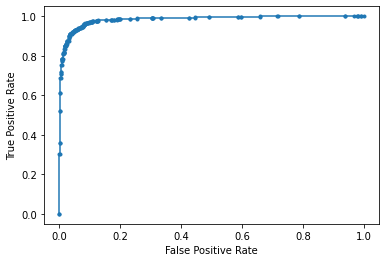

In [96]:
build_score(y_pred,y_test,probs)